In [1]:
!pip install keras

In [2]:
!conda install tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/ggayq/anaconda3:
#
tensorflow                1.3.0                         0  


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import os
import glob
#from face_detection import get_face, convert_to_face_only
from  sklearn.model_selection import train_test_split
from shutil import copyfile
# Keras stuff
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Reshape
import pickle
from face_detection import convert_to_face_only


Using TensorFlow backend.


## Set some important parameters

In [4]:
DATA_PATH = "img/" #where are the images located
MODEL_FILENAME= 'lfw_people_model_2.h5' #where to store the Keras model (including weights)
# Image dimensions for cropped pictures
FINAL_HEIGHT=120
FINAL_WIDTH=120

## Get an overview of the available  data

In [5]:
classes = [ name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name)) ]
nclasses = len(classes)
files = {cl:glob.glob(DATA_PATH+cl+"/*.jpg") for cl in classes}

In [6]:
for cl,fls in files.items():
    print("Category '{}' has {} images".format(cl,len(fls)))

Category 'Djork-Arne_Clevert' has 7 images
Category 'Andreas_Steffen' has 6 images
Category 'Eren_Elci' has 6 images


## Split into the training and test sets and run face detection

In [7]:
files_test = {}
files_train = {}
for cl in classes:
    files_train[cl], files_test[cl] = train_test_split(files[cl], test_size=1) # 2 pictures go into test set

In [8]:
# create the train/test - directory structure and put the cropped pictures into it
train_dest_directory = DATA_PATH[:-1]+"_Train_Test/"
if not os.path.exists(train_dest_directory):
    os.makedirs(train_dest_directory)

for t_ in ["Train", "Test"]:
    for cl,fns in files_test.items() if t_ == "Test" else files_train.items():
        tmp_dir = train_dest_directory+t_+"/"+cl+"/"
        #print(tmp_dir)
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)
        for f in fns:
            print(" ",f, "->", tmp_dir +f[f.rindex("/")+1:])
            # skip since pics are already cropped
            convert_to_face_only(f, tmp_dir +f[f.rindex("/")+1:], final_height=FINAL_HEIGHT, final_width=FINAL_WIDTH) # runs face detection! 120x120 pictures
            #copyfile(f,tmp_dir +f[f.rindex("/")+1:] )
            # face detection is based on default OpenCV (Haar) cascade filter
            # see also https://realpython.com/blog/python/face-recognition-with-python/
            #copyfile(f,tmp_dir +f[f.rindex("/")+1:])

  img/Djork-Arne_Clevert/039a506a-06cd-43b0-8ca9-627d559d8140.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/039a506a-06cd-43b0-8ca9-627d559d8140.jpg
  img/Djork-Arne_Clevert/f64f1097-f011-4694-8b23-45f1a25f682c.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/f64f1097-f011-4694-8b23-45f1a25f682c.jpg
  img/Djork-Arne_Clevert/2dee6eaa-12a0-414a-afef-0cbe4612e0d5.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/2dee6eaa-12a0-414a-afef-0cbe4612e0d5.jpg
  img/Djork-Arne_Clevert/b08e07b8-1770-4752-a6f7-b12e3db11d0a.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/b08e07b8-1770-4752-a6f7-b12e3db11d0a.jpg
  img/Djork-Arne_Clevert/853e2a0b-e1a3-45b8-a171-71a8d7fc00f7.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/853e2a0b-e1a3-45b8-a171-71a8d7fc00f7.jpg
  img/Djork-Arne_Clevert/6cc64627-fe6e-4292-a388-6c800bb25afc.jpg -> img_Train_Test/Train/Djork-Arne_Clevert/6cc64627-fe6e-4292-a388-6c800bb25afc.jpg
  img/Andreas_Steffen/a017f937-bd63-4785-bcc4-37b989ea3af7.jpg -> img_Train_Test/Train/Andreas_Steff

# Build the Keras model

![Typical CNN](typical_cnn.png)
Figure taken from "Hands-On Machine Learning with Scikit-Learn & TensorFlow"

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=( FINAL_HEIGHT, FINAL_WIDTH,3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.25)) #0.5 is too high

model.add(Dense(nclasses))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', #TODO: change this for multiclass cases
              optimizer='adam', #better
              metrics=['accuracy'])

## Create Pipeline 

In [10]:
batch_size = 1 # should be around 8 if we have 30pics per person
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255, #normalisation
        rotation_range=5, #play around with this
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of  train_dest_directory+'Train/', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dest_directory+'Train/',  # this is the target directory
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),  # in case we want to resize images
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
                              

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
       train_dest_directory+'Test/',
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),
        batch_size=batch_size,
        class_mode='categorical')

Found 16 images belonging to 3 classes.
Found 3 images belonging to 3 classes.


In [11]:
NIMAGES_IN_TRAIN = np.sum([len(f) for f in files_train.values()])
NIMAGES_IN_TEST = np.sum([len(f) for f in files_test.values()])
history = model.fit_generator(
        train_generator,
        steps_per_epoch=NIMAGES_IN_TRAIN // batch_size, 
        epochs=20, #was 50
        validation_data=validation_generator,
        validation_steps=NIMAGES_IN_TEST  ) #was 800

Epoch 1/20
16/16 [==============================] - 0s - loss: 1.1022 - acc: 0.1875 - val_loss: 1.0697 - val_acc: 0.3333
Epoch 2/20
16/16 [==============================] - 0s - loss: 1.1109 - acc: 0.3750 - val_loss: 1.0308 - val_acc: 0.3333
Epoch 3/20
16/16 [==============================] - 0s - loss: 1.0130 - acc: 0.5000 - val_loss: 0.9779 - val_acc: 0.3333
Epoch 4/20
16/16 [==============================] - 0s - loss: 0.9446 - acc: 0.5625 - val_loss: 0.8049 - val_acc: 0.6667
Epoch 5/20
16/16 [==============================] - 0s - loss: 0.7153 - acc: 0.7500 - val_loss: 0.6841 - val_acc: 0.6667
Epoch 6/20
16/16 [==============================] - 0s - loss: 0.7766 - acc: 0.6250 - val_loss: 0.6249 - val_acc: 1.0000
Epoch 7/20
16/16 [==============================] - 0s - loss: 0.7314 - acc: 0.7500 - val_loss: 0.6393 - val_acc: 1.0000
Epoch 8/20
16/16 [==============================] - 0s - loss: 0.4913 - acc: 0.8125 - val_loss: 0.5629 - val_acc: 0.6667
Epoch 9/20
16/16 [==============

In [12]:
model.save(MODEL_FILENAME)  # creates a HDF5 file 'lfw_people_model.h5'

In [13]:
# Allows us to resolve Keras internal class labels (back to folder names used in the App)
class_dictionary = train_generator.class_indices
ids_to_classes = [k for (k,v) in class_dictionary.items()]
with open(MODEL_FILENAME.replace("h5", "pickle"), 'wb') as handle:
    pickle.dump(ids_to_classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


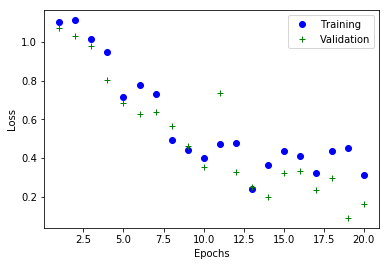

In [14]:
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
fig,ax = plt.subplots()
# "bo" is for "blue dot"
ax.plot(epochs, loss_values, 'bo',label="Training")
# g+ is for "green crosses"
ax.plot(epochs, val_loss_values, 'g+',label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc="best")
plt.show()

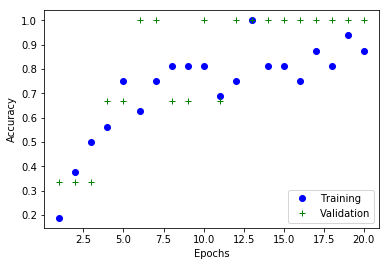

In [15]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
# "bo" is for "blue dot"
fig, ax = plt.subplots()
ax.plot(epochs, acc_values, 'bo', label="Training")
# b+ is for "green crosses"
ax.plot(epochs, val_acc_values, 'g+', label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc="best")
plt.show()

In [16]:
ls

face_detection.py       lfw_people_model_2.h5      __pycache__/
face recognition.ipynb  lfw_people_model_2.pickle  Training.ipynb
img/                    Predict.ipynb
img_Train_Test/         predict_label.py


In [17]:
from PIL import Image

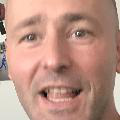

In [18]:
Image.open("img_Train_Test/Train/Djork-Arne_Clevert/039a506a-06cd-43b0-8ca9-627d559d8140.jpg")